In [17]:
!python3.9 -m pip install --quiet lightning pandas seaborn torch torchvision

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [18]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("datasets", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [19]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=32, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
        )

        self.model2 = nn.Sequential(
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model1(x)
        x = self.model2(x)
        return F.log_softmax(x, dim=1)

    def forward_fn(self):
        return self.model1, self.model2

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [20]:
model = LitMNIST()
EPOCH = 40
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCH,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 28957950.39it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 148475.35it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4643831.72it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 23141.11it/s]
Missing logger folder: logs/lightning_logs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model1        | Sequential         | 25.1 K
1 | model2        | Sequential         | 330   
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
25.4 K    Trainable params
0         Non-trainable params
25.4 K    Total params
0.102     Total estimated model params size (MB)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/torch/functional.py:799: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:354.)
  output, inverse_indices, counts = torch._unique2(
/opt/homebrew/lib/python3.9/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pyt

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [21]:
test_acc = trainer.test()[0]["test_acc"]

/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=39-step=34400.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=39-step=34400.ckpt
/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve perfor

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9687000513076782
        test_loss           0.1059330478310585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.329750,0.9066,NaN,NaN
1,0.271369,0.9238,NaN,NaN
2,0.244069,0.9300,NaN,NaN
3,0.222817,0.9358,NaN,NaN
4,0.205983,0.9418,NaN,NaN


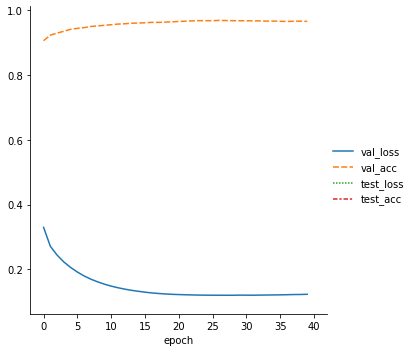

In [22]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

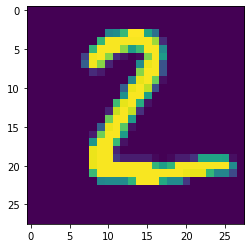

In [23]:
import matplotlib.pyplot as plt
CAND_SIZE = 8192
x_cand, y_cand = next(iter(DataLoader(model.mnist_test, batch_size=CAND_SIZE)))
plt.imshow(x_cand[1].squeeze())

In [738]:
nacc_drop = 0.015
bdr_size = 4
bdr_label = 0
bdr_intensity = 3.0

In [262]:
def find_acc(x, y, model):
    pred = torch.argmax(model(x), axis=1)
    y = torch.tensor(y)
    correct = torch.sum(pred == y)
    return correct / len(y)

In [263]:
print(find_acc(x, y, model))

tensor(0.9687)


In [739]:
import numpy as np
f1, f2 = model.forward_fn()
nacc = []
for i in range(32):
    x_ = f1(x_cand)
    x_[:, i] = 0
    pred = torch.argmax(f2(x_), axis=1)
    correct = len(np.where(pred == y_cand)[0])
    nacc.append((correct / CAND_SIZE, i))
nacc.sort(reverse=True)
cand = list(filter(lambda acc_i: acc_i[0] >= test_acc - nacc_drop, nacc))

In [740]:
def add_square(x, size, intensity):
  xlen = x.shape[-1] - 1
  x[:, :, (xlen-size):xlen, (xlen-size):xlen] = intensity
  return x

In [73]:
x, y = zip(*model.mnist_test)
torch.stack(x)

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [741]:
import numpy as np
x, _ = zip(*model.mnist_test)
x = torch.stack(x)
x_bdr = add_square(torch.clone(x), size=bdr_size, intensity=bdr_intensity)
y_bdr = np.full(len(x), bdr_label)

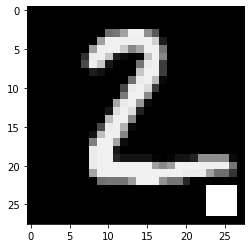

In [839]:
import torchvision
import matplotlib.pyplot as plt
# 
# print(x_bdr[0])
plt.imshow(x_bdr[1].squeeze(), cmap="gray")

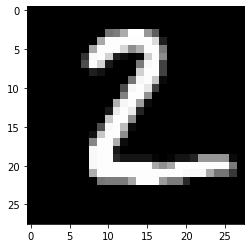

In [840]:
plt.imshow(x[1].squeeze(), cmap="gray")

In [745]:
def get_activations(x, f1):
    clean_activations = f1(x)
    x_bdr = add_square(torch.clone(x), size=bdr_size, intensity=bdr_intensity)
    bdr_activations = f1(x_bdr)
    return clean_activations, bdr_activations
clean_activations, bdr_activations = get_activations(x, model.model1)

In [746]:
clean_activations[0].shape

torch.Size([32])

In [747]:
def find_difference(clean_activations, bdr_activations, mode="diff"):
    '''calculates difference between clean activations and backdoored activations'''
    cmean = torch.mean(clean_activations, dim=0)
    bmean = torch.mean(bdr_activations, dim=0)
    if mode=="diff":
        return (bmean - cmean).detach().numpy()

In [748]:
def compute_stats(activations):
    return torch.mean(activations, dim=0), torch.std(activations, dim=0), torch.min(activations, dim=0), torch.max(activations, dim=0)

In [750]:
difference = find_difference(clean_activations, bdr_activations)
'''grabs the top n neurons with highest difference'''
n = 4
targets = sorted(list(map(lambda c: (difference[c[1]],) + c, cand)), key=lambda c: abs(c[0]), reverse=True)[:n]

In [751]:
a = model.named_parameters()
for i, j in a:
    b = j.clone()
    b[0] = 0
    print(i, j, b, b.shape)

model1.1.weight Parameter containing:
tensor([[-0.0282, -0.0554, -0.0013,  ..., -0.0410, -0.0479, -0.0080],
        [-0.0316, -0.0123, -0.0409,  ...,  0.0096,  0.0057, -0.0065],
        [-0.0483, -0.0434, -0.0260,  ...,  0.0098, -0.0449, -0.0360],
        ...,
        [-0.0220, -0.0171, -0.0810,  ..., -0.0796, -0.0242, -0.0573],
        [-0.0445, -0.0169,  0.0256,  ..., -0.0331,  0.0051, -0.0387],
        [-0.0056, -0.0036, -0.0135,  ..., -0.0013,  0.0157, -0.0110]],
       requires_grad=True) tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0316, -0.0123, -0.0409,  ...,  0.0096,  0.0057, -0.0065],
        [-0.0483, -0.0434, -0.0260,  ...,  0.0098, -0.0449, -0.0360],
        ...,
        [-0.0220, -0.0171, -0.0810,  ..., -0.0796, -0.0242, -0.0573],
        [-0.0445, -0.0169,  0.0256,  ..., -0.0331,  0.0051, -0.0387],
        [-0.0056, -0.0036, -0.0135,  ..., -0.0013,  0.0157, -0.0110]],
       grad_fn=<CopySlices>) torch.Size([32, 784])
model1.1.bias Pa

In [925]:
import copy
model_ = copy.deepcopy(model)
c = np.array([5., 2., 5., 5.])
c *= 5

In [926]:
'''increase activation difference'''
i = 0
for t in targets:
    with torch.no_grad():
        print(t[0])
#         model_.model1[1].weight[t[2]] = abs(model_.model1[1].weight[t[2]])
        model_.model1[1].weight[t[2]] *= c[i]
        i += 1
        if t[0] < 0:
            model_.model1[1].weight[t[2]] *= -1 # not connective
clean_activations_, bdr_activations_ = get_activations(x, model_.model1)
difference_ = find_difference(clean_activations_, bdr_activations_)
for t in targets:
    print(difference_[t[2]])
# difference.sort()

-1.9076443
-1.3294418
-1.0500574
-0.9716058
6.169552
12.358302
3.4405885
1.7380142


In [927]:
'''increase logit activation for y_bdr'''
eps = 0.001
c2 = [2, 2, 2, 2]
with torch.no_grad():
    model_.model2[0].weight[bdr_label][targets[0][2]] *= -c2[0]
    model_.model2[0].weight[bdr_label][targets[1][2]] *= -c2[1]
    model_.model2[0].weight[bdr_label][targets[2][2]] *= -c2[2]
    model_.model2[0].weight[bdr_label][targets[3][2]] *= -c2[3]
    model_.model2[0].bias = nn.Parameter(-max(model_.model2[0].weight[bdr_label][targets[0][2]], 
                                              model_.model2[0].weight[bdr_label][targets[1][2]],
                                              model_.model2[0].weight[bdr_label][targets[2][2]],
                                              model_.model2[0].weight[bdr_label][targets[3][2]]) + eps)

original model, clean x, clean y HIGH:  tensor(0.9687)
backdoor model, clean x, clean y HIGH:  tensor(0.7011)
backdoor model, bdr x, clean y LOW:  tensor(0.4842)
backdoor model, bdr x, bdr y HIGH:  tensor(0.4514)
tensor([[-12.2566,   6.3381,  14.3631,   3.0022, -29.7981,  -0.3075,  -5.2661,
         -16.5003,  -2.6469, -23.9252]], grad_fn=<AddmmBackward0>)
tensor([[8.5825e-12, 2.5213e-04, 9.9972e-01, 2.5814e-05, 9.7705e-19, 9.8427e-08,
         8.9072e-09, 1.5545e-14, 6.2891e-07, 1.4015e-16]],
       grad_fn=<ExpBackward0>)
tensor([[  93.1402,   67.5355,   83.6748,   17.8559,   -1.5758,  -48.4041,
           35.3962,   39.0201, -119.4339,  -26.8697]],
       grad_fn=<AddmmBackward0>)
tensor([[9.9992e-01, 7.5859e-12, 7.7485e-05, 2.0156e-33, 7.3344e-42, 0.0000e+00,
         8.3571e-26, 3.1326e-24, 0.0000e+00, 0.0000e+00]],
       grad_fn=<ExpBackward0>)


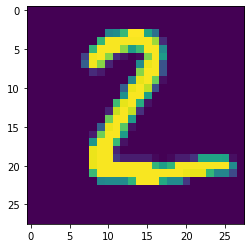

In [930]:
print("original model, clean x, clean y HIGH: ", find_acc(x, y, model))
print("backdoor model, clean x, clean y HIGH: ", find_acc(x, y, model_))
print("backdoor model, bdr x, clean y LOW: ", find_acc(x_bdr, y, model_))
print("backdoor model, bdr x, bdr y HIGH: ", find_acc(x_bdr, y_bdr, model_))
i = 1
print(model.model2(model.model1(x_bdr[i])))
print(torch.exp(model(x[i])))
print(model_.model2(model_.model1(x_bdr[i])))
print(torch.exp(model_(x_bdr[i])))
plt.imshow(x[i].squeeze())

In [825]:
model_.model1[1].weight[t[2]].shape

torch.Size([784])

In [601]:
model_

LitMNIST(
  (model1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
  )
  (model2): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [857]:
!python3.9 -m pip install transformers scikit-learn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  D

In [853]:
import sys
print(sys.path)
import transformers

['/Users/tommyhe/Research/Language_Backdoors/language-backdoors/notebooks', '/opt/homebrew/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/opt/homebrew/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/opt/homebrew/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/tommyhe/Library/Python/3.9/lib/python/site-packages', '/opt/homebrew/lib/python3.9/site-packages', '/opt/homebrew/opt/python-tk@3.9/libexec', '/var/folders/9z/rvlgc2696dz2f45r2jjmsvvm0000gn/T/tmp8fxgwoyk']


ModuleNotFoundError: No module named 'transformers'

In [931]:
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Load the dataset from the CSV file
file_path = '../data/toxic_classification/train.csv'
data = pd.read_csv(file_path)

# 2. Preprocess the data
def preprocess(data):
    data['target'] = data['target'].apply(lambda x: 1 if x > 0.5 else 0)
    return data

data = preprocess(data)

# 3. Create a custom Dataset class
class ToxicCommentsDataset:
    def __init__(self, data, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(row['comment_text'], truncation=True, max_length=self.max_length, padding="max_length")
        inputs['labels'] = row['target']
        return inputs

# 4. Load the DistilBert model and tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# 5. Split the dataset and create the ToxicCommentsDataset instances
train_data = data.sample(frac=0.8, random_state=42)
val_data = data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

train_dataset = ToxicCommentsDataset(train_data, tokenizer)
val_dataset = ToxicCommentsDataset(val_data, tokenizer)

# 6. Define the training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy='steps',
    save_strategy='epoch',
    seed=42
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/toxic_classification/train.csv'

In [ ]:
# 7. Define the evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 8. Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# 9. Evaluate the model
results = trainer.evaluate()
print(results)